In [7]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import skorch
import numpy as np

from torch.autograd import Variable

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

In [9]:
from torch.utils.data import DataLoader, TensorDataset
from sine_data import train_dataset, valid_dataset

In [23]:
class GaussClocking(nn.Module):
    def __init__(self, input_dim, hidden_dim, act='tanh'):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        self.i2h = nn.Linear(input_dim, hidden_dim)
        self.h2h = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.m = nn.Parameter(torch.ones(hidden_dim) - 0.5)
        self.s = nn.Parameter(torch.ones(hidden_dim))
        self.act = {'relu': nn.ReLU, 'tanh': nn.Tanh}[act]()
        
    def forward(self, x, h=None): # x is (b, t, u) 
        if h is None:
            h = torch.zeros(self.hidden_dim)
            h = skorch.utils.to_var(h, x.is_cuda)
            
        clks = torch.randn(x.size(1), self.hidden_dim)
        clks = skorch.utils.to_var(clks, x.is_cuda)
            
        ys = []
        cs = []
        for ti in range(x.size(1)):
            clock_gate = clks[ti] * self.s + self.m
            clock_gate = F.sigmoid(clock_gate)

            h_new = self.i2h(x[:, ti]) + self.h2h(h)
            h = clock_gate * h_new + (1 - clock_gate) * h
            y = self.act(h)
            ys.append(y)
            cs.append(clock_gate)
        return torch.stack(ys, dim=1), h, torch.stack(cs, dim=0)

In [24]:
import visdom
vis = visdom.Visdom()

In [25]:
X_train, y_train = train_dataset(points=200)
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset(points=400)
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

sine_train_loader = DataLoader(TensorDataset(X_train, y_train),
                               batch_size=64,
                               shuffle=True)
sine_valid_loader = DataLoader(TensorDataset(X_valid, y_valid),
                               batch_size=64,
                               shuffle=False)

In [26]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)

In [31]:
class ReconModel(nn.Module):
    def __init__(self, num_hidden=64, act='tanh', num_layers=1):
        super().__init__()
        
        self.rnn = []
        self.num_layers = num_layers
        
        for i in range(num_layers):
            input_dim = 1 if i == 0 else num_hidden
            self.rnn.append(GaussClocking(input_dim, num_hidden, act=act))
            self.add_module('rnn'+str(i), self.rnn[-1])
        
        self.clf = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        li = x
        for i in range(self.num_layers):
            li, hi, ci = self.rnn[i](li)
            vis.heatmap(skorch.utils.to_numpy(li[0]), opts={'title': 'act rnn'+str(i)}, win="act rnn"+str(i))
            vis.heatmap(skorch.utils.to_numpy(self.rnn[i].m).reshape(1, -1), opts={'title': 'mu rnn'+str(i)}, win="mu rnn"+str(i))
            vis.heatmap(skorch.utils.to_numpy(self.rnn[i].s).reshape(1, -1), opts={'title': 's rnn'+str(i)}, win="s rnn"+str(i))
        l1 = self.clf(time_flatten(li))
        return time_unflatten(l1, x.size())

In [32]:
class Trainer(skorch.NeuralNet):
    def __init__(
        self, 
        criterion=nn.MSELoss,
        *args, 
        **kwargs
    ):
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, training=False):
        pred = time_flatten(y_pred)
        true = time_flatten(y_true)
        return super().get_loss(pred, true, X=X, training=training)

In [33]:
torch.manual_seed(1337)

def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef = Trainer(module=ReconModel,
             optimizer=torch.optim.Adam,
             lr=0.02,
             max_epochs=40,
             train_split=my_train_split,
             
             module__num_hidden=16,
             module__act='relu',
             module__num_layers=2,
             use_cuda=False,
            )

In [34]:
%pdb on
ef.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.3037        0.7864  0.4091
      2        0.7939        0.3381  0.4058
      3        0.4630        0.2906  0.4672
      4        0.3167        0.2604  0.4654
      5        0.2844        0.1472  0.4164
      6        0.1787        0.1213  0.4399
      7        0.1827        0.1200  0.4120
      8        0.1761        0.0669  0.4164
      9        0.0973        0.0776  0.4352
     10        0.0935        0.0861  0.4280
     11        0.0982        0.0652  0.4070
     12        0.0762        0.0304  0.4793
     13        0.0460        0.0165  0.5017
     14        0.0357        0.0239  0.4124
     15        0.0465        0.0174  0.4350
     16        0.0349        0.0242  0.4954
     17        0.0356        0.0345  0.4360
     18        0.0430        0.0130  0.4184
     19        0.0239        0.0136  0.4749
     20        0.0237        0.0134

<class '__main__.Trainer'>[initialized](
  module_=ReconModel(
    (rnn0): GaussClocking(
      (i2h): Linear(in_features=1, out_features=16)
      (h2h): Linear(in_features=16, out_features=16)
      (act): ReLU()
    )
    (rnn1): GaussClocking(
      (i2h): Linear(in_features=16, out_features=16)
      (h2h): Linear(in_features=16, out_features=16)
      (act): ReLU()
    )
    (clf): Linear(in_features=16, out_features=1)
  ),
)

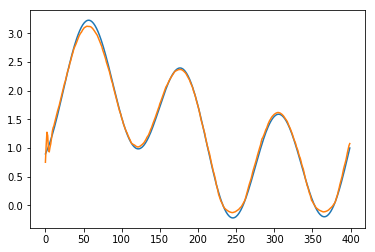

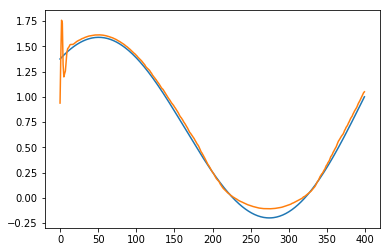

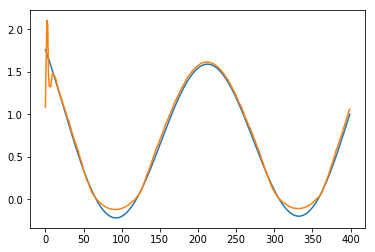

In [35]:
data = X_valid
pred = ef.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])